# Import dependencies

In [ ]:
import os
import time
import pandas
import pickle
import numpy as np

import matplotlib.pyplot as plt

import pickle

!pip install tensorflow-gpu==2.3.1
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda, Cropping2D, ZeroPadding2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

tf.compat.v1.disable_eager_execution()

print(tf.__version__)

# Load data

In [2]:
dir = '/content/drive/My Drive/vae-speech'

data = np.load(dir + '/male.npy', allow_pickle=True)

data.shape

(2489, 513, 63)

# Prepare data

In [3]:
def update_dimension():
  new_data = []

  for idx, wav in enumerate(data):
    d = np.delete(data[idx], -1, axis=0)
    z = np.zeros((len(d), 1))
    d = np.append(d, z, axis = 1)
    new_data.append(d)

  return np.array(new_data)

In [4]:
nd = update_dimension()
n = len(nd)

#reshape the data
nd = np.reshape(nd, (len(nd), 512, 64, 1))


x_train = nd[:int(0.6*n)]
x_test = nd[int(-0.4*n):]

print("new dimension: " + str(nd.shape))
print("training size: " + str(len(x_train)))
print("testing size: " + str(len(x_test)))

new dimension: (2489, 512, 64, 1)
training size: 1493
testing size: 995


# Model generation

In [9]:
shape = 1

learning_rate = 0.001 #@param {type:"raw"}
num_epochs_to_train = 30 #@param {type:"integer"}
batch_size = 32 #@param {type:"integer"}
vector_dimension = 512 #@param {type:"integer"}

sampling_rate = 16000 #@param {type:"integer"}

In [6]:
class VAE:
  def __init__(self,
               input_shape, #shape of the input data
               conv_filters, #convolutional network filters
               conv_kernels, #convNet kernel size
               conv_strides, #convNet strides
               latent_space_dim):
    self.input_shape = input_shape # (513, 63)
    self.conv_filters = conv_filters # is a list for each layer, i.e. [2, 4, 8]
    self.conv_kernels = conv_kernels # list of kernels per layer, [1, 2, 3]
    self.conv_strides = conv_strides # stride for each filter [1, 2, 2], note: 2 means you are downsampling the data in half
    self.latent_space_dim = latent_space_dim # how many neurons on bottleneck
    self.reconstruction_loss_weight = 1000000

    self.encoder = None
    self.decoder = None
    self.model = None
    self.hist = None

    self._num_conv_layers = len(conv_filters)
    self._shape_before_bottleneck = None
    self._model_input = None

    self._build()

  def summary(self):
    self.encoder.summary()
    print("\n")
    self.decoder.summary()
    print("\n")
    self.model.summary()

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_autoencoder()

  def compile(self, learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    self.model.compile(optimizer=optimizer, loss=self._calculate_combined_loss,
                      metrics=[self._calculate_reconstruction_loss, self._calculate_kl_loss])
  
  def train(self, x_train, batch_size, num_epochs):
    self.hist= self.model.fit(x_train,
                              x_train,
                              batch_size=batch_size,
                              epochs=num_epochs,
                              shuffle=True)

  def _calculate_combined_loss(self, y_target, y_predicted):
    reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
    kl_loss = self._calculate_kl_loss(y_target, y_predicted)
    combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss
    return combined_loss
  
  def _calculate_reconstruction_loss(self, y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss

  def _calculate_kl_loss(self, y_target, y_predicted):
    kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                          K.exp(self.log_variance), axis =1)
    return kl_loss
  
  def save(self, save_folder):
    self._create_folder_if_it_doesnt_exist(save_folder)
    self._save_parameters(save_folder)
    self._save_weights(save_folder)

  def _create_folder_if_it_doesnt_exist(self, folder):
      if not os.path.exists(folder):
          os.makedirs(folder)

  def _save_parameters(self, save_folder):
      parameters = [
          self.input_shape,
          self.conv_filters,
          self.conv_kernels,
          self.conv_strides,
          self.latent_space_dim
      ]
      save_path = os.path.join(save_folder, "parameters.pkl")
      with open(save_path, "wb") as f:
          pickle.dump(parameters, f)

  def _save_weights(self, save_folder):
      save_path = os.path.join(save_folder, "weights.h5")
      self.model.save_weights(save_path)

  #----------------FULL MODEL-----------------#
  def _build_autoencoder(self):
    model_input = self._model_input
    model_output = self.decoder(self.encoder(model_input))
    self.model = Model(model_input, model_output, name="autoencoder")

  #----------------DECODER-----------------#
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.decoder = Model(decoder_input, decoder_output, name="decoder")

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name="decoder_input")

  def _add_dense_layer(self, decoder_input):
    num_neurons = np.prod(self._shape_before_bottleneck) # [ 1, 2, 4] -> 8
    dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
    return dense_layer

  def _add_reshape_layer(self, dense_layer):
    return Reshape(self._shape_before_bottleneck)(dense_layer)

  def _add_conv_transpose_layers(self, x):
    for layer_index in reversed(range(1, self._num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self, layer_index, x):
    layer_num = self._num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters=self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{layer_num}"
    )
    x = conv_transpose_layer(x)
    x = ReLU(name=f"decoder_relu_{layer_num}")(x)
    x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
    return x

  def _add_decoder_output(self, x):
    conv_transpose_layer = Conv2DTranspose(
        filters = 1,
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
    )
    x = conv_transpose_layer(x)
    output_layer = Activation("sigmoid", name="sigmoid_output_layer")(x)
    return output_layer

  #----------------ENCODER-----------------#
  def _build_encoder(self):
    encoder_input = self._add_encoder_input()
    # x = Cropping2D(cropping=((1, 0), (0,0)))(encoder_input)
    # x = ZeroPadding2D(padding=((0, 0), (1,0)))(x)
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck =  self._add_bottleneck(conv_layers)
    self._model_input = encoder_input
    self.encoder = Model(encoder_input, bottleneck, name="encoder")

  def _add_encoder_input(self):
    return Input(shape=self.input_shape, name="encoder_input")

  def _add_conv_layers(self, encoder_input):
    """Creates all convolutional blocks in encoder"""
    x = encoder_input
    for layer_index in range(self._num_conv_layers):
      x = self._add_conv_layer(layer_index, x)
    return x
  
  def _add_conv_layer(self, layer_index, x):
    """
    Adds a convolutional block to a graph of layers, consisting
    of Conv 2d + ReLu activation + batch normalization.
    """
    layer_number = layer_index + 1
    conv_layer = Conv2D(
        filters= self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name = f"encoder_conv_layer_{layer_number}"
    )
    x = conv_layer(x)
    x = ReLU(name=f"encoder_relu_{layer_number}")(x)
    x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
    return x

  #-------------LATTENT SPACE-------------#
  def _add_bottleneck(self, x):
    """Flatten data and add bottleneck with Gaussian sampling (Dense layer)"""
    self._shape_before_bottleneck = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.mu = Dense(self.latent_space_dim,name="mu")(x)
    self.log_variance = Dense(self.latent_space_dim,
                              name="log_variance")(x)
    
    def sample_point_from_normal_distribution(args):
      mu, log_variance = args
      epsilon = K.random_normal(shape=K.shape(self.mu), mean=0., stddev=1.)
      sampled_point = mu + K.exp(log_variance / 2) * epsilon

      return sampled_point

    x = Lambda(sample_point_from_normal_distribution, 
              name="encoder_output")([self.mu, self.log_variance])
    return x

# Model training

In [17]:
def model():
  vae = VAE(
      input_shape = (512, 64, 1),
      conv_filters=(512, 256, 128, 64, 32),
      conv_kernels=(3, 3, 3, 3, 3),
      conv_strides=(2, 2, 2, 2, (2,1)),
      latent_space_dim = vector_dimension
  )
  return vae

def train(x_train, learning_rate, batch_size, epochs): 
  vae = model()
  vae.summary()
  vae.compile(learning_rate)
  vae.train(x_train, batch_size, epochs)
  return vae

In [ ]:
def get_time_stamp():
  secondsSinceEpoch = time.time()
  timeObj = time.localtime(secondsSinceEpoch)
  x = ('%d_%d_%d_%d%d' % (timeObj.tm_mday, timeObj.tm_mon, timeObj.tm_year, timeObj.tm_hour, timeObj.tm_min))
  return x

current_time = get_time_stamp()

model_name = "simple_vae" #@param {type:"string"}
save_dir = "/content/drive/My Drive/vae-speech/" #@param {type:"string"}

print(x_train.shape)
vae = train(x_train, learning_rate, batch_size, num_epochs_to_train)

vae.save(f"{save_dir}{model_name}_{current_time}__w{shape}sec_z{vector_dimension}")

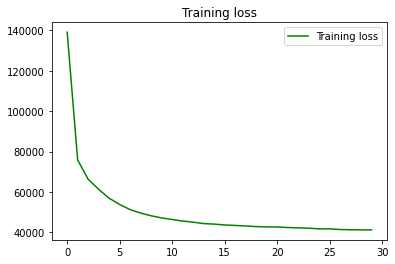

In [12]:
loss = vae.hist.history['loss']

epochs = range(num_epochs_to_train)

plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Evaluate

In [13]:
def plot_specgram(spec, sample_rate, title="Spectrogram", xlim=None):
  spec = np.reshape(spec, (512, 64))
  num_freq, num_frames = spec.shape
  time_axis = np.arange(0, num_frames) / sample_rate
  freq_axis = np.arange(0, num_freq) * sample_rate/2/num_freq
  figure, axes = plt.subplots(1, 1)
  axes.pcolormesh(time_axis, freq_axis, spec[:,:], cmap='viridis')
  axes.set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

In [22]:
dir = '/content/drive/My Drive/vae-speech/simple_vae_3_3_2022_1422__w1sec_z512/'


vae = model()
vae.model.load_weights(dir+'weights.h5')
# ae_save = tf.keras.models.load_model(dir+'weights.h5')

decoded_specgram = vae.model.predict(x_test)

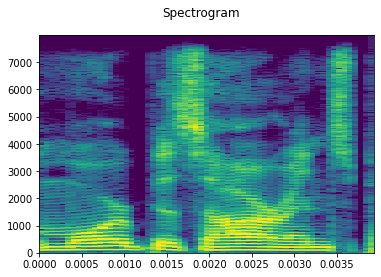

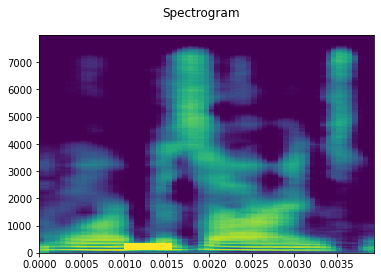

In [23]:
plot_specgram(x_test[0], sampling_rate)
plot_specgram(decoded_specgram[0], sampling_rate)